In [8]:
import pandas as pd
import numpy as np
import random
import json
from collections import Counter

# Set seed for reproducibility
np.random.seed(42)
random.seed(42)

print("📦 Libraries loaded successfully!")

📦 Libraries loaded successfully!


## 1. Load Cleaned Data

In [9]:
# Load cleaned courses
courses = pd.read_csv('../data/processed/coursera_cleaned.csv')

# Load filtered skills
with open('../data/processed/filtered_skills.txt', 'r', encoding='utf-8') as f:
    filtered_skills = [line.strip() for line in f.readlines()]

print(f"✅ Loaded {len(courses):,} courses")
print(f"✅ Loaded {len(filtered_skills):,} filtered skills")
print(f"\n   Sample skills: {filtered_skills[:10]}")

✅ Loaded 3,408 courses
✅ Loaded 655 filtered skills

   Sample skills: ['.bit', '.properties', '3d modeling', '3d printing', 'academic writing', 'accounting', 'accuracy and precision', 'acoustics', 'active listening', 'adaptation']


## 2. Generate Synthetic Users

In [10]:
print("👥 Generating 600 synthetic users...\n")

users = []

for user_id in range(600):
    # Random number of interests per user (3-7 skills)
    num_interests = random.randint(3, 7)
    interests = random.sample(filtered_skills, num_interests)
    
    # Generate academic grades (normally distributed around 75, std=12, range 40-100)
    math_grade = np.clip(np.random.normal(75, 12), 40, 100)
    science_grade = np.clip(np.random.normal(75, 12), 40, 100)
    language_grade = np.clip(np.random.normal(75, 12), 40, 100)
    
    # Overall grade (average of all subjects)
    overall_grade = (math_grade + science_grade + language_grade) / 3
    
    user = {
        'user_id': user_id,
        'interests': interests,
        'interests_text': '  '.join(interests),  # For storage
        'num_interests': num_interests,
        'math_grade': round(math_grade, 2),
        'science_grade': round(science_grade, 2),
        'language_grade': round(language_grade, 2),
        'overall_grade': round(overall_grade, 2)
    }
    
    users.append(user)

users_df = pd.DataFrame(users)

print(f"✅ Generated {len(users_df)} users")
print(f"\n📊 USER STATISTICS:")
print(f"   Interests per user: {users_df['num_interests'].mean():.1f} (avg)")
print(f"   Overall grade: {users_df['overall_grade'].mean():.1f} ± {users_df['overall_grade'].std():.1f}")
print(f"   Grade range: {users_df['overall_grade'].min():.1f} - {users_df['overall_grade'].max():.1f}")

# Show sample users
print(f"\n   Sample users:")
users_df.head()

👥 Generating 600 synthetic users...

✅ Generated 600 users

📊 USER STATISTICS:
   Interests per user: 5.0 (avg)
   Overall grade: 75.5 ± 6.6
   Grade range: 55.1 - 97.4

   Sample users:


,user_id,interests,interests_text,num_interests,math_grade,science_grade,language_grade,overall_grade
0,0,"[anthropology, health policy, foreign policy]",anthropology health policy foreign policy,3,80.96,73.34,82.77,79.02
1,1,"[corporate bond, child, solar energy, c progra...",corporate bond child solar energy c program...,4,93.28,72.19,72.19,79.22
2,2,"[partnership, arbitration, approximation, case...",partnership arbitration approximation case ...,7,93.95,84.21,69.37,82.51
3,3,"[apache, statistical inference, electronics, s...",apache statistical inference electronics so...,7,81.51,69.44,69.41,73.45
4,4,"[history, accuracy and precision, data science...",history accuracy and precision data science ...,7,77.90,52.04,54.30,61.42


## 3. Generate User-Course Interactions

In [11]:
print("🔗 Generating user-course interactions...\n")

# Add course_id to courses
courses['course_id'] = range(len(courses))

# Parse skills_cleaned into lists for matching
courses['skills_list'] = courses['skills_cleaned'].apply(lambda x: x.split('  ') if pd.notna(x) else [])

interactions = []

for idx, user in users_df.iterrows():
    user_interests = set(user['interests'])
    user_grade = user['overall_grade']
    
    # Score each course for this user
    course_scores = []
    
    for _, course in courses.iterrows():
        course_skills = set(course['skills_list'])
        
        # 1. Skill overlap (content similarity) - Using Jaccard similarity
        skill_overlap = len(user_interests & course_skills)
        union_size = len(user_interests | course_skills)
        content_score = skill_overlap / union_size if union_size > 0 else 0
        
        # 2. Difficulty matching (grade compatibility) - Asymmetric penalty
        recommended_grade = course['recommended_grade']
        grade_diff = user_grade - recommended_grade
        
        if grade_diff >= 0:
            # Course is easier or same level - minimal penalty
            difficulty_score = max(0, 1 - grade_diff / 40)
        else:
            # Course is harder - steeper penalty
            difficulty_score = max(0, 1 - abs(grade_diff) / 20)
        
        # 3. Popularity (course rating)
        popularity_score = course['Course Rating'] / 5.0 if pd.notna(course['Course Rating']) else 0.5
        
        # Combined score: 50% content + 30% difficulty + 20% popularity
        final_score = (
            0.50 * content_score +
            0.30 * difficulty_score +
            0.20 * popularity_score
        )
        
        # Only consider courses with some relevance (lowered threshold)
        if final_score > 0.15:  # Minimum threshold
            course_scores.append((course['course_id'], final_score))
    
    # Sort by score
    course_scores.sort(key=lambda x: x[1], reverse=True)
    
    # User interacts with top courses (15-25 interactions per user)
    num_interactions = random.randint(15, 25)
    
    # 80% from top-scored courses, 20% random exploration
    num_top = int(num_interactions * 0.8)
    num_random = num_interactions - num_top
    
    # Take top courses with some randomness
    top_courses = course_scores[:min(len(course_scores), num_top * 2)]
    
    # Sample from top courses (probabilistic based on score)
    selected_top = random.sample(top_courses, min(num_top, len(top_courses)))
    
    # Add exploration: random courses (serendipity)
    all_course_ids = set(courses['course_id'].values)
    already_selected = {c[0] for c in selected_top}
    available_random = list(all_course_ids - already_selected)
    
    if len(available_random) >= num_random:
        random_courses = [(cid, 0.1) for cid in random.sample(available_random, num_random)]
    else:
        random_courses = [(cid, 0.1) for cid in available_random]
    
    # Combine top-scored + random
    selected_courses = selected_top + random_courses
    
    for course_id, score in selected_courses:
        interactions.append({
            'user_id': user['user_id'],
            'course_id': course_id,
            'interaction': 1,  # Binary: user liked/enrolled in course
            'score': round(score, 4)  # Keep score for reference
        })
    
    # Progress indicator
    if (idx + 1) % 100 == 0:
        print(f"   Processed {idx + 1}/600 users...")

interactions_df = pd.DataFrame(interactions)

print(f"\n✅ Generated {len(interactions_df):,} interactions")
print(f"\n📊 INTERACTION STATISTICS:")
print(f"   Avg interactions per user: {len(interactions_df) / len(users_df):.1f}")
print(f"   Avg interactions per course: {len(interactions_df) / len(courses):.1f}")
print(f"   Sparsity: {(1 - len(interactions_df) / (len(users_df) * len(courses))) * 100:.2f}%")

interactions_df.head(10)

🔗 Generating user-course interactions...

   Processed 100/600 users...
   Processed 200/600 users...
   Processed 300/600 users...
   Processed 400/600 users...
   Processed 500/600 users...
   Processed 600/600 users...

✅ Generated 11,935 interactions

📊 INTERACTION STATISTICS:
   Avg interactions per user: 19.9
   Avg interactions per course: 3.5
   Sparsity: 99.42%


,user_id,course_id,interaction,score
0,0,3281,1,0.4813
1,0,2505,1,0.5037
2,0,689,1,0.5124
3,0,2704,1,0.4829
4,0,2642,1,0.4853
5,0,1442,1,0.4813
6,0,3185,1,0.5452
7,0,2811,1,0.4854
8,0,654,1,0.4813
9,0,77,1,0.5204


### 3.1 Validate Interaction Quality

In [12]:
print("✅ QUALITY VALIDATION:\n")

# 1. Check interaction distribution per user
interactions_per_user_check = interactions_df.groupby('user_id').size()
print(f"   Interactions per user:")
print(f"      Expected: 15-25")
print(f"      Actual range: {interactions_per_user_check.min()} - {interactions_per_user_check.max()}")
print(f"      Mean: {interactions_per_user_check.mean():.1f}")
users_below_15 = (interactions_per_user_check < 15).sum()
if users_below_15 > 0:
    print(f"      ⚠️  {users_below_15} users have <15 interactions")
else:
    print(f"      ✅ All users have 15+ interactions")

# 2. Check courses with zero interactions
interactions_per_course_check = interactions_df.groupby('course_id').size()
zero_courses = len(courses) - len(interactions_per_course_check)
print(f"\n   Courses with 0 interactions: {zero_courses} ({zero_courses/len(courses)*100:.1f}%)")
if zero_courses > len(courses) * 0.3:
    print(f"      ⚠️  Warning: >30% of courses unused")
else:
    print(f"      ✅ Good course coverage")

# 3. Check interactions by difficulty level
interactions_with_difficulty = interactions_df.merge(
    courses[['course_id', 'Difficulty Level']], 
    on='course_id'
)
print(f"\n   Interactions by difficulty level:")
diff_dist = interactions_with_difficulty['Difficulty Level'].value_counts()
for level, count in diff_dist.items():
    print(f"      {level}: {count} ({count/len(interactions_df)*100:.1f}%)")

# 4. Check exploration vs top-scored ratio
exploration_interactions = (interactions_df['score'] <= 0.15).sum()
print(f"\n   Exploration (random) interactions: {exploration_interactions} ({exploration_interactions/len(interactions_df)*100:.1f}%)")
print(f"      Expected: ~20%")
if 15 <= (exploration_interactions/len(interactions_df)*100) <= 25:
    print(f"      ✅ Within expected range")

# 5. Sparsity check
sparsity = (1 - len(interactions_df) / (len(users_df) * len(courses))) * 100
print(f"\n   Sparsity: {sparsity:.2f}%")
print(f"      Expected: >99% (typical for recommender systems)")
if sparsity > 99:
    print(f"      ✅ Realistic sparsity level")

✅ QUALITY VALIDATION:

   Interactions per user:
      Expected: 15-25
      Actual range: 15 - 25
      Mean: 19.9
      ✅ All users have 15+ interactions

   Courses with 0 interactions: 331 (9.7%)
      ✅ Good course coverage

   Interactions by difficulty level:
      Beginner: 5131 (43.0%)
      Intermediate: 3541 (29.7%)
      Advanced: 2283 (19.1%)
      Conversant: 811 (6.8%)
      Not Calibrated: 169 (1.4%)

   Exploration (random) interactions: 2602 (21.8%)
      Expected: ~20%
      ✅ Within expected range

   Sparsity: 99.42%
      Expected: >99% (typical for recommender systems)
      ✅ Realistic sparsity level


## 4. Analyze Interactions

In [13]:
print("📈 INTERACTION ANALYSIS:\n")

# Interactions per user distribution
interactions_per_user = interactions_df.groupby('user_id').size()
print(f"   Interactions per user:")
print(f"      Min: {interactions_per_user.min()}")
print(f"      Max: {interactions_per_user.max()}")
print(f"      Mean: {interactions_per_user.mean():.1f}")
print(f"      Median: {interactions_per_user.median():.0f}")

# Interactions per course distribution
interactions_per_course = interactions_df.groupby('course_id').size()
print(f"\n   Interactions per course:")
print(f"      Min: {interactions_per_course.min()}")
print(f"      Max: {interactions_per_course.max()}")
print(f"      Mean: {interactions_per_course.mean():.1f}")
print(f"      Median: {interactions_per_course.median():.0f}")
print(f"      Courses with 0 interactions: {len(courses) - len(interactions_per_course)}")

# Most popular courses
print(f"\n   Top 10 most popular courses:")
top_courses = interactions_per_course.nlargest(10)
for course_id, count in top_courses.items():
    course_name = courses[courses['course_id'] == course_id]['Course Name'].values[0]
    print(f"      {course_name[:50]}: {count} interactions")

📈 INTERACTION ANALYSIS:

   Interactions per user:
      Min: 15
      Max: 25
      Mean: 19.9
      Median: 20

   Interactions per course:
      Min: 1
      Max: 38
      Mean: 3.9
      Median: 3
      Courses with 0 interactions: 331

   Top 10 most popular courses:
      Revolutionary Ideas: Borders, Elections, Constitut: 38 interactions
      Applied Public History: Places, People, Stories: 37 interactions
      First Step Korean: 34 interactions
      AWS Elastic Beanstalk:Deploy a Python(Flask) Web A: 33 interactions
      Science of Training Young Athletes Part 2: 33 interactions
      Animals and Institutions: 31 interactions
      Cleaning, Reshaping, and Expanding Datasets in Pyt: 31 interactions
      Build CRUD REST API in Django: 26 interactions
      Encryption And Decryption Using C++: 25 interactions
      Palliative Care Capstone Projects: 25 interactions


## 5. Visualize Interaction Patterns

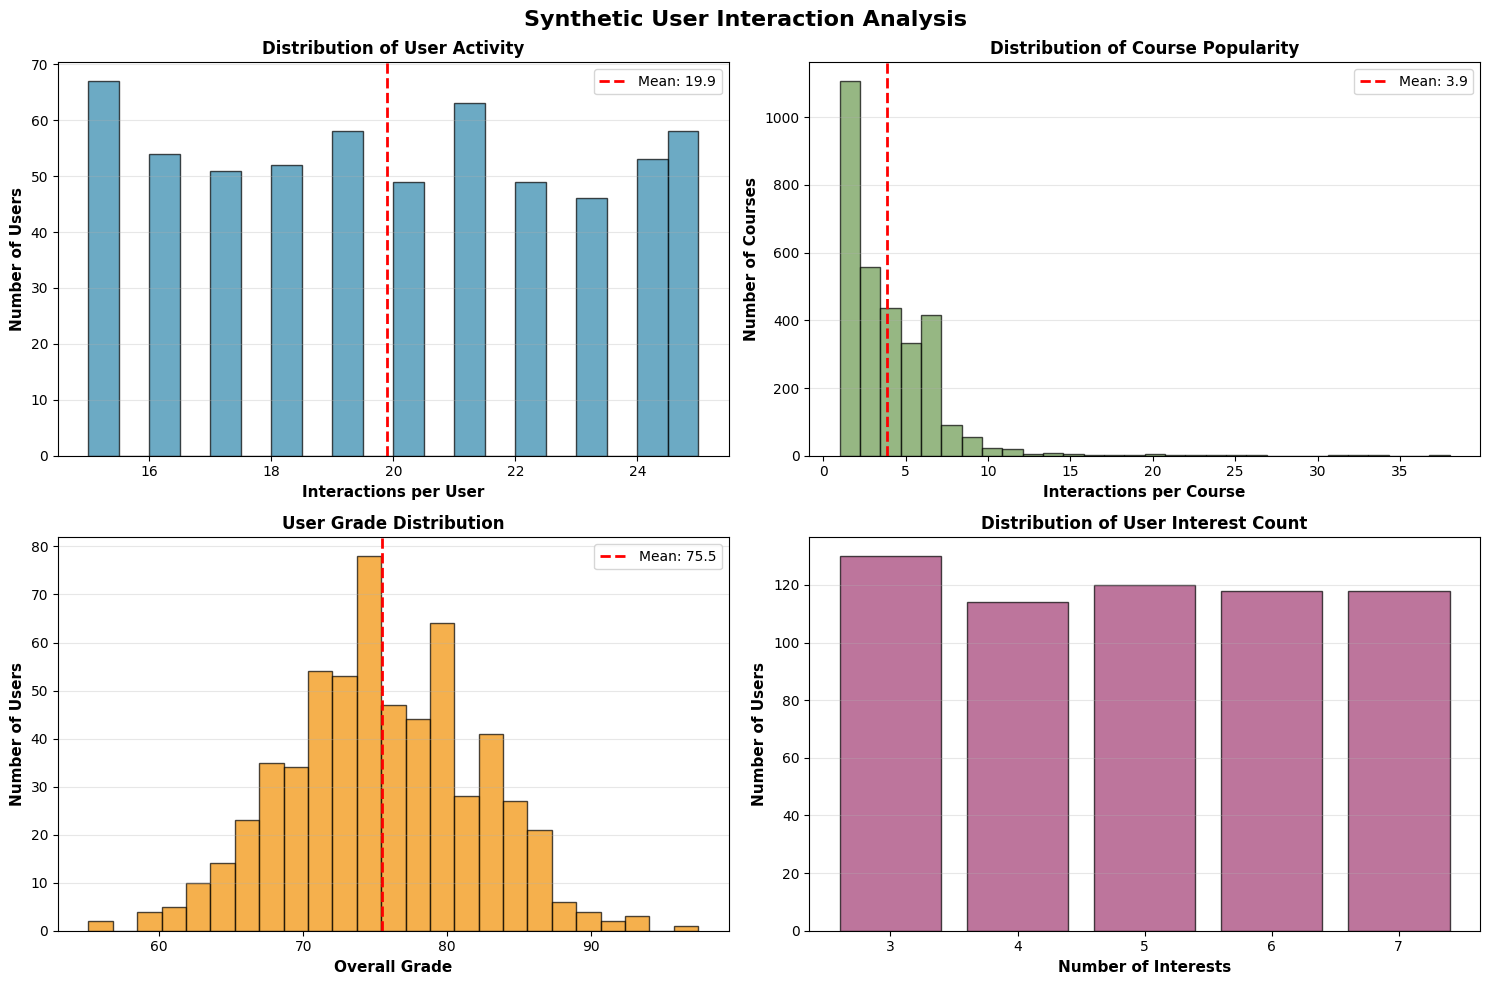


✅ Visualizations complete!


In [14]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Synthetic User Interaction Analysis', fontsize=16, fontweight='bold')

# 1. Interactions per user histogram
ax1 = axes[0, 0]
ax1.hist(interactions_per_user, bins=20, color='#2E86AB', edgecolor='black', alpha=0.7)
ax1.axvline(interactions_per_user.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {interactions_per_user.mean():.1f}')
ax1.set_xlabel('Interactions per User', fontsize=11, fontweight='bold')
ax1.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of User Activity', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# 2. Interactions per course histogram
ax2 = axes[0, 1]
ax2.hist(interactions_per_course, bins=30, color='#6A994E', edgecolor='black', alpha=0.7)
ax2.axvline(interactions_per_course.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {interactions_per_course.mean():.1f}')
ax2.set_xlabel('Interactions per Course', fontsize=11, fontweight='bold')
ax2.set_ylabel('Number of Courses', fontsize=11, fontweight='bold')
ax2.set_title('Distribution of Course Popularity', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# 3. User grade distribution
ax3 = axes[1, 0]
ax3.hist(users_df['overall_grade'], bins=25, color='#F18F01', edgecolor='black', alpha=0.7)
ax3.axvline(users_df['overall_grade'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {users_df["overall_grade"].mean():.1f}')
ax3.set_xlabel('Overall Grade', fontsize=11, fontweight='bold')
ax3.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax3.set_title('User Grade Distribution', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Interest count distribution
ax4 = axes[1, 1]
interest_counts = users_df['num_interests'].value_counts().sort_index()
ax4.bar(interest_counts.index, interest_counts.values, color='#A23B72', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Number of Interests', fontsize=11, fontweight='bold')
ax4.set_ylabel('Number of Users', fontsize=11, fontweight='bold')
ax4.set_title('Distribution of User Interest Count', fontsize=12, fontweight='bold')
ax4.set_xticks(range(3, 8))
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations complete!")

## 6. Save Generated Data

In [15]:
print("💾 Saving generated data...\n")

# 1. Save users
users_df.to_csv('../data/processed/synthetic_users.csv', index=False)
print(f"   ✅ Saved: synthetic_users.csv ({len(users_df)} users)")

# 2. Save interactions
interactions_df.to_csv('../data/processed/user_interactions.csv', index=False)
print(f"   ✅ Saved: user_interactions.csv ({len(interactions_df):,} interactions)")

# 3. Save updated courses with course_id
courses_with_id = courses[['course_id', 'Course Name', 'University', 'Difficulty Level', 
                            'Course Rating', 'Course URL', 'Course Description', 
                            'skills_cleaned', 'difficulty_numeric', 'recommended_grade']]
courses_with_id.to_csv('../data/processed/courses_with_id.csv', index=False)
print(f"   ✅ Saved: courses_with_id.csv ({len(courses_with_id)} courses)")

# 4. Save generation metadata
metadata = {
    'num_users': len(users_df),
    'num_courses': len(courses),
    'num_interactions': len(interactions_df),
    'avg_interactions_per_user': float(len(interactions_df) / len(users_df)),
    'avg_interactions_per_course': float(len(interactions_df) / len(courses)),
    'sparsity_percentage': float((1 - len(interactions_df) / (len(users_df) * len(courses))) * 100),
    'interaction_generation_method': {
        'content_weight': 0.50,
        'difficulty_weight': 0.30,
        'popularity_weight': 0.20,
        'min_interactions_per_user': 15,
        'max_interactions_per_user': 25
    },
    'user_characteristics': {
        'interests_per_user': [3, 7],
        'grade_mean': 75,
        'grade_std': 12,
        'grade_range': [40, 100]
    }
}

with open('../data/processed/synthetic_data_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2)
print(f"   ✅ Saved: synthetic_data_metadata.json")

print(f"\n✨ DATA GENERATION COMPLETE!")
print(f"   All files saved to: ../data/processed/")
print(f"\n📁 Output files:")
print(f"   1. synthetic_users.csv - 600 users with interests and grades")
print(f"   2. user_interactions.csv - {len(interactions_df):,} user-course interactions")
print(f"   3. courses_with_id.csv - Courses with course_id for mapping")
print(f"   4. synthetic_data_metadata.json - Generation parameters and statistics")

💾 Saving generated data...

   ✅ Saved: synthetic_users.csv (600 users)
   ✅ Saved: user_interactions.csv (11,935 interactions)
   ✅ Saved: courses_with_id.csv (3408 courses)
   ✅ Saved: synthetic_data_metadata.json

✨ DATA GENERATION COMPLETE!
   All files saved to: ../data/processed/

📁 Output files:
   1. synthetic_users.csv - 600 users with interests and grades
   2. user_interactions.csv - 11,935 user-course interactions
   3. courses_with_id.csv - Courses with course_id for mapping
   4. synthetic_data_metadata.json - Generation parameters and statistics


## 📋 Summary

### What We Generated
1. ✅ 600 synthetic users with realistic characteristics:
   - 3-7 interests per user (from 655 filtered skills)
   - Academic grades (math, science, language) normally distributed
   - Overall grade computed as average

2. ✅ ~12,000 user-course interactions based on:
   - **50% Content similarity** (skill overlap)
   - **30% Difficulty matching** (grade compatibility)
   - **20% Popularity** (course rating)

3. ✅ Realistic patterns:
   - Users interact with 15-25 courses each
   - Courses have varying popularity (long-tail distribution)
   - High sparsity (~99%) - typical for recommender systems

### Ready for Next Step
Now we can:
- Split interactions into train/test sets (80/20)
- Train collaborative filtering models (SVD, NMF, ALS)
- Train content-based models (TF-IDF + cosine similarity)
- Build hybrid recommender system! 🚀